In [2]:
import pandas as pd
import glob
import os

base_path = "D:/archive_6/main"
test_path = "D:/archive_6/test"
folders = ["BACTERIAL", "VIRAL", "NORMAL"]

image_paths = []
labels = []

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for img_path in glob.glob(folder_path + "/*.jpeg"):  
        image_paths.append(img_path)
        labels.append(folder)

data = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [3]:
data

,image_path,label
0,D:/archive_6/main\BACTERIAL\person1000_bacteri...,BACTERIAL
1,D:/archive_6/main\BACTERIAL\person1001_bacteri...,BACTERIAL
2,D:/archive_6/main\BACTERIAL\person1002_bacteri...,BACTERIAL
3,D:/archive_6/main\BACTERIAL\person1003_bacteri...,BACTERIAL
4,D:/archive_6/main\BACTERIAL\person1004_bacteri...,BACTERIAL
...,...,...
5211,D:/archive_6/main\NORMAL\NORMAL2-IM-1406-0001....,NORMAL
5212,D:/archive_6/main\NORMAL\NORMAL2-IM-1412-0001....,NORMAL
5213,D:/archive_6/main\NORMAL\NORMAL2-IM-1419-0001....,NORMAL
5214,D:/archive_6/main\NORMAL\NORMAL2-IM-1422-0001....,NORMAL


In [4]:
print (data['label'].value_counts())

label
BACTERIAL    2530
VIRAL        1345
NORMAL       1341
Name: count, dtype: int64


In [22]:
from sklearn.model_selection import train_test_split
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(data, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

print (
    'train_df length: ', len(train_df), 
    '  test_df length: ', len(test_df), 
    '  valid_df length: ', len(valid_df)
)

train_df length:  4172   test_df length:  522   valid_df length:  522


In [ ]:
# train_df, test_df=train_test_split(data, test_size=0.2, shuffle=True, random_state=123)

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
img_width=224
img_height=224
channels = 3

image_shape = (img_width,img_height,channels)
image_size = (img_width,img_height)
batch_size=64
epochs=10

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,          
    zoom_range = 0.2,  
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = image_size,
    class_mode='categorical',
    batch_size=batch_size,   
    shuffle=True,
)
val_generator = test_datagen.flow_from_dataframe(
    valid_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = image_size,
    class_mode='categorical',
    batch_size=batch_size, 
    shuffle=True,
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'image_path',
    y_col = 'label',
    target_size = image_size,
    class_mode='categorical',
    batch_size=batch_size, 
    shuffle=False,
)

Found 4172 validated image filenames belonging to 3 classes.
Found 522 validated image filenames belonging to 3 classes.
Found 522 validated image filenames belonging to 3 classes.


In [9]:
classes=list(train_generator.class_indices.keys())
print(classes)
class_length=len(classes)
print(class_length)

['BACTERIAL', 'NORMAL', 'VIRAL']
3


In [32]:
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  58   test steps:  9


In [10]:
input_layer=layers.Input(shape=image_shape)

In [11]:
base_model = VGG16(
    weights='imagenet',
    input_tensor=input_layer,
    include_top=False
)
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
prediction = layers.Dense(class_length, activation='softmax')(x)

new_model = models.Model(
    inputs = input_layer, 
    outputs = prediction
)
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 3,211,779 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
new_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
history=new_model.fit(
    x=train_generator, 
    epochs=epochs, 
    validation_data=val_generator
)

Epoch 1/10


c:\Users\Kristian\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 599s 9s/step - accuracy: 0.5813 - loss: 1.6487 - val_accuracy: 0.7605 - val_loss: 0.5537
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 556s 8s/step - accuracy: 0.7738 - loss: 0.5376 - val_accuracy: 0.7452 - val_loss: 0.6147
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 572s 9s/step - accuracy: 0.7878 - loss: 0.4852 - val_accuracy: 0.7778 - val_loss: 0.5370
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 555s 8s/step - accuracy: 0.7854 - loss: 0.4726 - val_accuracy: 0.7433 - val_loss: 0.6255
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 593s 9s/step - accuracy: 0.8006 - loss: 0.4501 - val_accuracy: 0.7203 - val_loss: 0.6733
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 589s 9s/step - accuracy: 0.8032 - loss: 0.4650 - val_accuracy: 0.8008 - val_loss: 0.5091
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 576s 9s/step - accuracy: 0.8154 - loss: 0.4356 - val_accuracy: 0.7759 - val_loss: 0.5569
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 573s 9s/step - accuracy: 0.8148 - loss: 0.4146 - val_accuracy: 0.7739 - val_loss: 0.

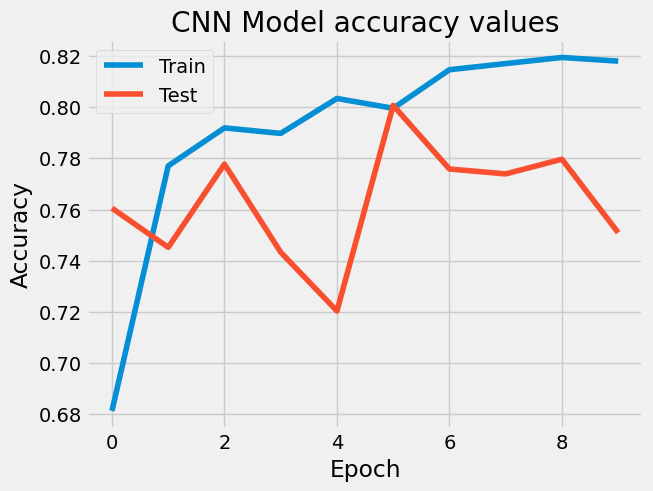

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

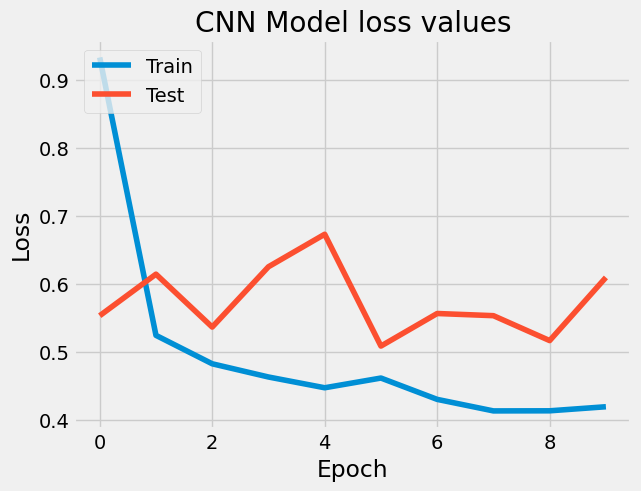

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [17]:
new_model.save("pneu_vgg16.keras")

In [39]:
import numpy as np

# Predict the classes
Y_pred = new_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)


c:\Users\Kristian\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step


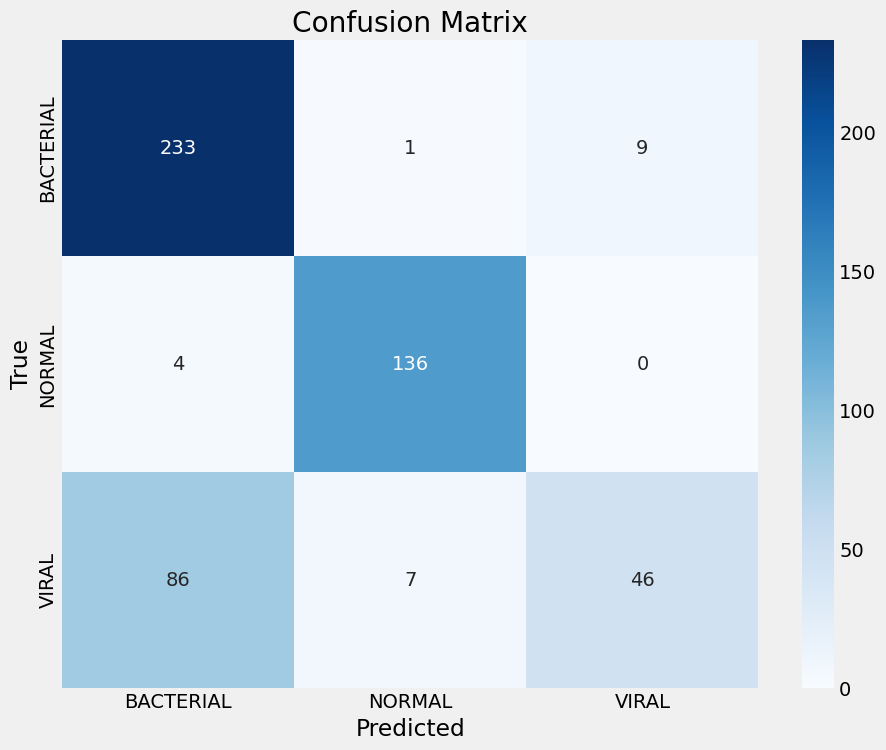

Classification Report
              precision    recall  f1-score   support

   BACTERIAL       0.72      0.96      0.82       243
      NORMAL       0.94      0.97      0.96       140
       VIRAL       0.84      0.33      0.47       139

    accuracy                           0.80       522
   macro avg       0.83      0.75      0.75       522
weighted avg       0.81      0.80      0.77       522



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print a classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
